In [28]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Rescorla-Wagner model of classical conditioning 
The Rescorla-Wagner model of associative learning states that animals learn by storing associations between stimuli and rewards, and that these associations are updated using prediction errors. We can implement this model in a few simple lines of code:

In [29]:
def rescorla_wagner_update(w, stimuli, reward):
    expected_reward = np.dot(w, stimuli)
    prediction_error = reward - expected_reward
    new_w = w + learning_rate * prediction_error * stimuli
    return new_w

Let's now simulate a simple conditioning + extinction paradigm whereby one stimulus is paired with reward for 100 trials, followed by 100 trials of extinction (the stimulus is shown but no reward is received). 

### Exercise 1.1
Can you reason about why the learning and extinction curves look like a logarithmic function? 

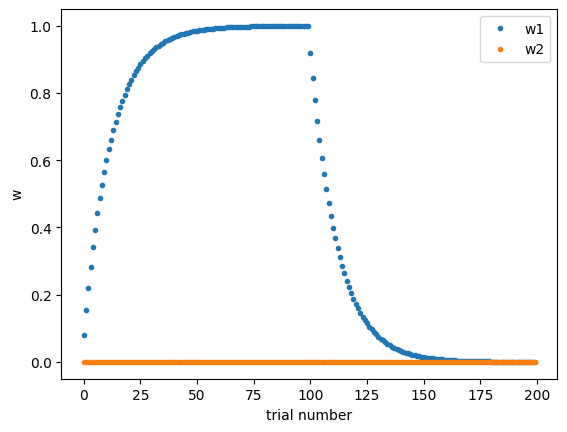

In [100]:
# initialize some parameters 
learning_rate = .08
n_stimuli = 2

# intialize the weights to zeros (no prior reward expectation)
w = np.zeros(n_stimuli)

ws = []
for trial in range(200):
    stimuli = np.array([1, 0])
    if trial < 100:
        reward = 1
    else:
        reward = 0

    w = rescorla_wagner_update(w, stimuli, reward)

    ws.append(w)

plt.plot(ws, '.')
plt.xlabel('trial number')
plt.ylabel('w')
plt.legend(['w1', 'w2'])

## Forward blocking, overshadowing and overexpectation

In forward blocking, a first cue A is first paired with reward until asymptote, after which A is paired with reward in compound with B. Subsequently we measure conditioned responding to cue B \
A —> +  \
AB —> + \
B —> ? 

### Exercise 1.2
What do you expect the conditioned responding to B to be like, given the Rescorla-Wagner learning rule? 

Let's simulate this below: 

In [101]:
# intialize the weights to zeros (no prior reward expectation)
w = np.zeros(n_stimuli)

ws = []
for trial in range(200):
    reward = 1
    if trial < 100:
        stimuli = np.array([1, 0])
    else:
        stimuli = np.array([1, 1])

    w = rescorla_wagner_update(w, stimuli, reward)

    ws.append(w)


In [102]:
print(f'conditioned response to B: {np.dot(np.array([0,1]), w)}')

conditioned response to B: 0.00011960593412453592


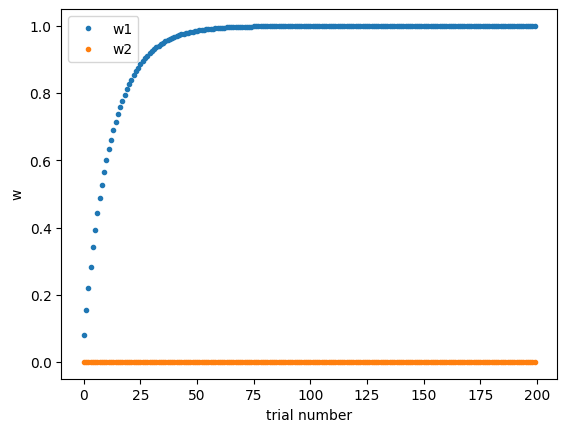

In [103]:
plt.plot(ws, '.')
plt.xlabel('trial number')
plt.ylabel('w')
plt.legend(['w1', 'w2'])


### Exercise 1.3

In overshadowing, two stimuli are presented together. What should we expect conditioned responding to B to be, after this paradigm? \
AB—> + \
B —> ?

In overexpectation, we pair A and B independently with reward, until asymptote, before the compound phase. What happens to the A and B associations during this compound learning phase? \
A—>+ \
B—>+ \
AB—>+ \
B—>?

Can you show what the RW model predicts in these cases? 

In [104]:
# write your code here 

# 2. Kalman Filter model of classical conditioning

The Rescorla-Wagner model gives the maximum-likelihood estimate of the weights, but does not give an estimate of the uncertainty the animal might have about these weights. A Bayesian generalization of the RW model leads to the Kalman Filter. 

In [105]:
def kalman_filter_update(mean_w, covariance, stimuli, reward):

    # Prediction step;
    a_priori_covariance = covariance + transition_noise_variance * np.eye(len(mean_w))

    # Compute statistics of interest;
    expected_reward = np.dot(stimuli, mean_w)
    prediction_error = reward - expected_reward  # the "prediction error". Actually expected value of the prediction error
    residual_cov = np.dot(stimuli, np.matmul(a_priori_covariance, stimuli)) + observation_noise_variance

    # Correction step;
    kalman_gain = np.matmul(a_priori_covariance, stimuli) * residual_cov**-1
    mean_w = mean_w + kalman_gain * prediction_error  # weight update
    covariance = a_priori_covariance - np.outer(kalman_gain, residual_cov*kalman_gain)  # covariance update 

    return mean_w, covariance

Let's simulate a very simple paradigm whereby a single stimulus is presented many times without any reward for 100 trials, after which the stimulus is paired with a reward for another 100 trials. 

### Exercise 2.1
What happens to the variance estimate during the first 100 trials? What does this mean for subsequent conditioning? How does this differ from the original Rescorla-Wagner model?

Text(0, 0.5, 'w')

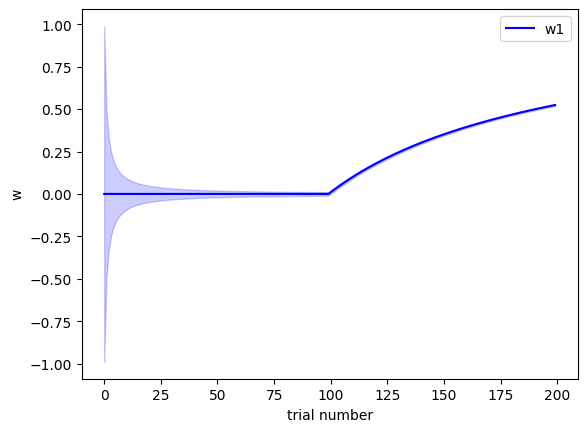

In [111]:
# initialize some parameters 
n_stimuli = 2
transition_noise_variance = 1e-5
observation_noise_variance = 1.
prior_covariance = 100 * np.eye(n_stimuli)
trials = np.arange(200)

# intialize the weights to zeros (no prior reward expectation)
w = np.zeros(n_stimuli)

ws = []
covs = []
covariance = prior_covariance 
for trial in trials:
    stimuli = np.array([1, 0])
    if trial < 100:
        reward = 0
    else:
        reward = 1

    w, covariance = kalman_filter_update(w, covariance, stimuli, reward)

    ws.append(w)
    covs.append(covariance)

# now plot the uncertainty as shaded errorbars
w1_mean = np.array(ws)[:, 0]
w1_var = np.array(covs)[:, 0, 0]

plt.plot(trials, w1_mean, color='blue')
plt.legend(['w1', 'w2'])

# Add shaded uncertainty area around w1
plt.fill_between(trials, w1_mean - w1_var, w1_mean + w1_var, color='blue', alpha=0.2)

plt.xlabel('trial number')
plt.ylabel('w')


### Exercise 2.2
In part 1, we simulated the forward blocking phenomenon using Rescorla-Wagner. Animals also show a 'backward blocking' phenomenon, where blocking occurs even if the compound phase is shown before A is paired with reward alone, as below:

AB —> + \
A —> +  \
B —> ? 

Simulate this paradigm using both the RW and KF models, and explain what you see. Why do or don't these two models show backward blocking?


In [ ]:
# write your code here 

# 3. Temporal difference (TD) learning

With the TD learning model, we can model reinforcement learning over time within the trial. This allows us to model what the TD prediction error looks like at different times within the trial, across different stages of learning. Below is an implementation of the TD update. 

In [183]:
def temporal_difference_update(w, current_stimulus, next_stimulus, reward):
    expected_reward =  np.dot(w, current_stimulus) - gamma * np.dot(w, next_stimulus) 
    prediction_error = reward - expected_reward
    new_w = w + learning_rate * prediction_error * current_stimulus
    return new_w, prediction_error

Let's use this model to simulate a simple conditioning paradigm where a single stimulus is reliably followed by reward later in the same trial. We can show what the prediction error looks like at different points in the trial, early during learning as well as late. 

In [189]:
# First, we need to represent the stimuli, as well as a representation of the stimuli over time. We'll use the 
# complete serial compound representation (see slides).

def construct_stimulus(trial_length, onset, duration):
    """
    Args:
        - 'trial_length': length of trial in time steps 
        - 'onset': onset of each stimulus (time step). This is a list with length n_stimuli.
        - 'duration': duration of each stimulus (as above) 
    """
    n_stimuli = len(onset)
    stimulus = np.zeros((trial_length, n_stimuli))
    for i in range(n_stimuli):
        stimulus[onset[i]:onset[i]+duration[i], i] = 1
    return stimulus


def construct_csc(stimulus):
    x = np.array([]).reshape(stimulus.shape[0], 0)
    for d in range(stimulus.shape[1]):
        diag_matrix = np.diag(stimulus[:, d])
        x = np.hstack((x, diag_matrix))
    return x


# set some parameters
learning_rate = .1 
gamma = .99
n_trials = 1000
n_time_steps = 20

stim = construct_stimulus(n_time_steps, [5], [20])
x = construct_csc(stim)
reward = construct_stimulus(n_time_steps, [15], [1])

# initialize weight to zero
d = x.shape[0]
w = np.zeros(d)

ws = []
errors = []

# learn for
prediction_errors = []
for trial in range(n_trials):
    trial_errors = []
    for time_step in range(n_time_steps-1):
        w, delta = temporal_difference_update(w, x[time_step], x[time_step+1], reward[time_step+1])
        trial_errors.append(delta)
    prediction_errors.append(trial_errors)


prediction_errors = np.array(prediction_errors)

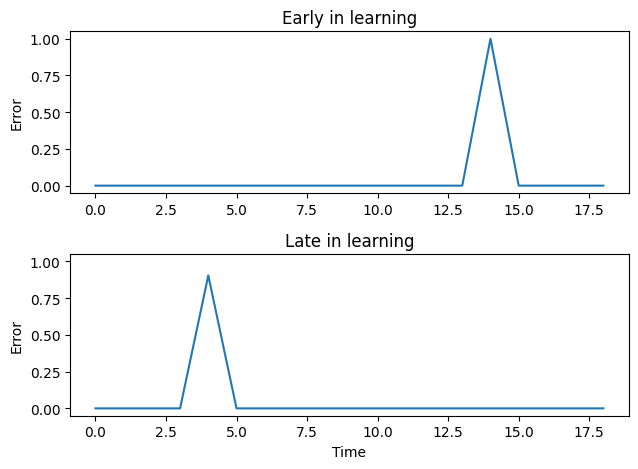

In [198]:
fig, axes = plt.subplots(2, 1, sharey=True)
axes[0].plot(prediction_errors[0, :])
axes[0].set_title('Early in learning')
axes[1].plot(prediction_errors[-1, :])
axes[1].set_title('Late in learning')
plt.xlabel('Time')
plt.ylabel('Error')
axes[0].set_ylabel('Error')
plt.tight_layout()

### Exercise 3.1
Can you guess what would happen to this error if the reward was omitted? Simulate this to verify. 

### Exercise 3.2
Show what happens to the prediction error between the first and last trials. Is this a realistic model of what dopamine neurons do? 